In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
class OptionDataset(Dataset):
    def __init__(self, csv_file):
        # Read the data from CSV
        self.data = pd.read_csv(csv_file)
        # Using 'S_t', 'I_t', and 't' as features and 'F' as the target
        self.X = self.data[['S_t', ' I_t', ' t']].values.astype(np.float32)
        self.y = self.data[' F'].values.astype(np.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class OptionNet(nn.Module):
    def __init__(self):
        super(OptionNet, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
dataroot = "Datasets/"

# HPs
batch_size = 1024
learning_rate = 0.001
num_epochs = 50

train_dataset = OptionDataset(dataroot + "Training_dataset.csv")
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = OptionDataset(dataroot + "Test_dataset.csv")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Epoch 1/50 | Train Loss: 47.0769 | Test Loss: 0.7733
Epoch 2/50 | Train Loss: 46.4792 | Test Loss: 0.5927
Epoch 3/50 | Train Loss: 46.1974 | Test Loss: 0.4090
Epoch 4/50 | Train Loss: 45.9856 | Test Loss: 0.5457
Epoch 5/50 | Train Loss: 45.9051 | Test Loss: 0.1734
Epoch 6/50 | Train Loss: 45.8657 | Test Loss: 0.2531
Epoch 7/50 | Train Loss: 45.8336 | Test Loss: 0.2982
Epoch 8/50 | Train Loss: 45.8238 | Test Loss: 0.1652
Epoch 9/50 | Train Loss: 45.8019 | Test Loss: 0.1654
Epoch 10/50 | Train Loss: 45.7930 | Test Loss: 0.1577
Epoch 11/50 | Train Loss: 45.7870 | Test Loss: 0.2039
Epoch 12/50 | Train Loss: 45.7829 | Test Loss: 0.0953
Epoch 13/50 | Train Loss: 45.7706 | Test Loss: 0.0554
Epoch 14/50 | Train Loss: 45.7652 | Test Loss: 0.0677
Epoch 15/50 | Train Loss: 45.7588 | Test Loss: 0.1127
Epoch 16/50 | Train Loss: 45.7587 | Test Loss: 0.2274
Epoch 17/50 | Train Loss: 45.7583 | Test Loss: 0.1118
Epoch 18/50 | Train Loss: 45.7480 | Test Loss: 0.0499
Epoch 19/50 | Train Loss: 45.7524 | T

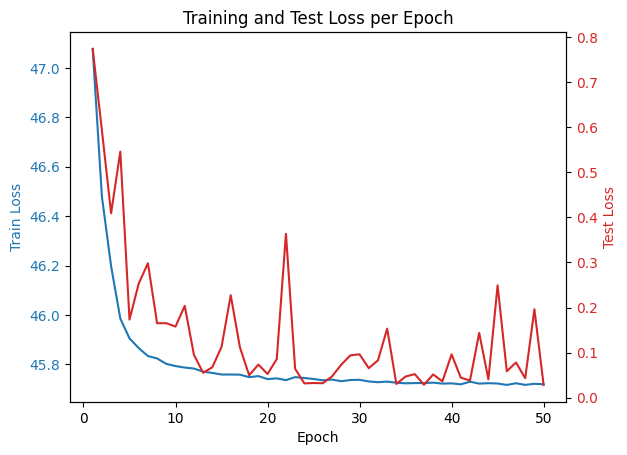

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OptionNet().to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store losses
train_losses = []
test_losses = []

# Training loop with evaluation on the test set
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for X_batch, y_batch in train_dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)  # shape: [batch_size, 1]
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
    
    train_loss = running_loss / len(train_dataset)
    train_losses.append(train_loss)
    
    # Evaluate on test set
    model.eval()  # Set model to evaluation mode
    test_running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_running_loss += loss.item() * X_batch.size(0)
    test_loss = test_running_loss / len(test_dataset)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}')

# Plot the training and test losses on two different y-axes
epochs = range(1, num_epochs+1)
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(epochs, train_losses, color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Test Loss', color=color)
ax2.plot(epochs, test_losses, color=color, label='Test Loss')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training and Test Loss per Epoch')
plt.show()

In [ ]:
# Test on the validation

val_dataset = OptionDataset(dataroot + "Validation_dataset.csv")
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

val_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in val_dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        val_loss += loss.item() * X_batch.size(0)

final_val_loss = val_loss / len(val_dataset)
print(f'Final Validation Loss: {final_val_loss:.4f}')

Final Validation Loss: 0.0282


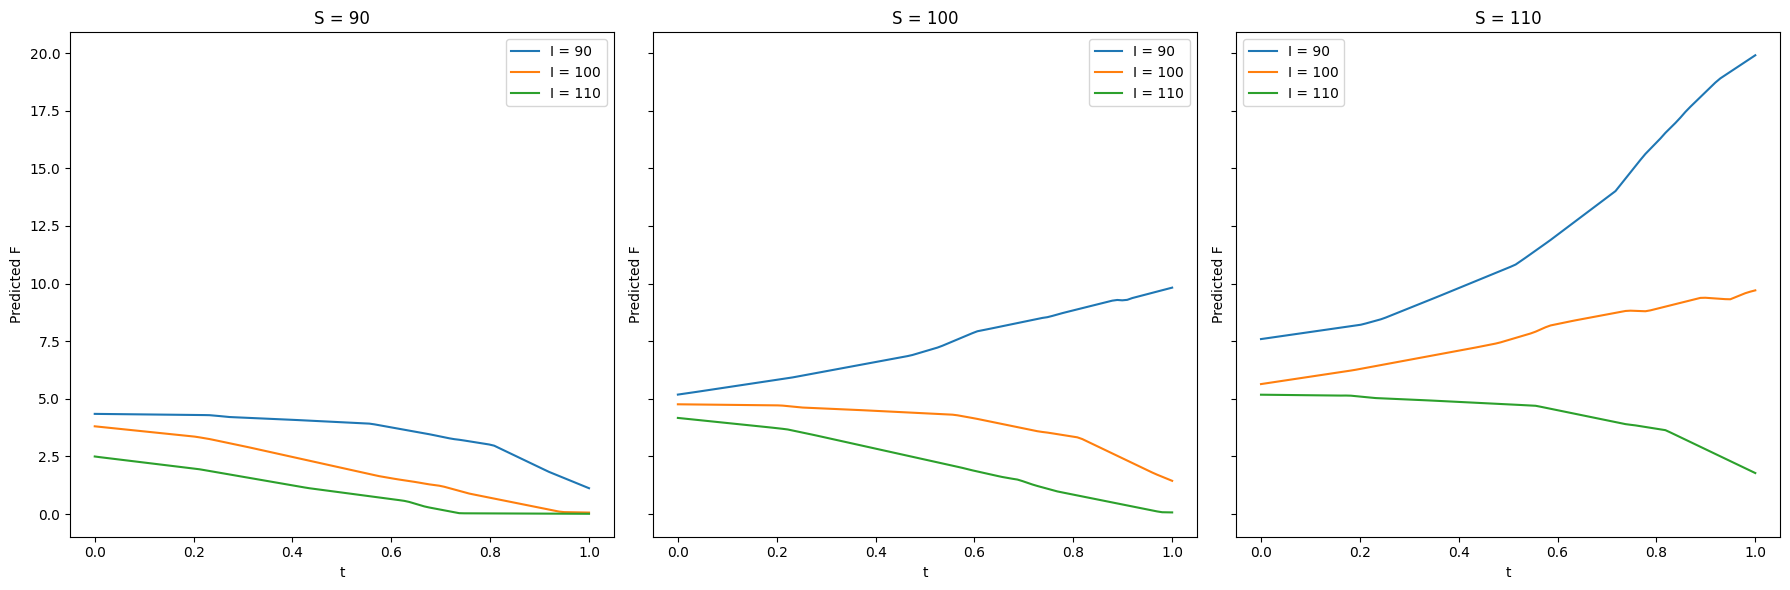

In [57]:
t_values = np.linspace(0, 1, 100, dtype=np.float32)

fixed_pairs = [
    (90, 90),
    (90, 100),
    (90, 110),
    (100, 90),
    (100, 100),
    (100, 110),
    (110, 90),
    (110, 100),
    (110, 110),
]

pairs_by_S = {}
for S_val, I_val in fixed_pairs:
    if S_val not in pairs_by_S:
        pairs_by_S[S_val] = []
    pairs_by_S[S_val].append(I_val)

unique_S = sorted(pairs_by_S.keys())
fig, axes = plt.subplots(1, len(unique_S), figsize=(18, 6), sharey=True)
if len(unique_S) == 1:
    axes = [axes]

model.eval()
with torch.no_grad():
    for idx, S_val in enumerate(unique_S):
        ax = axes[idx]
        for I_val in pairs_by_S[S_val]:
            S_arr = np.full_like(t_values, S_val)
            I_arr = np.full_like(t_values, I_val)
            inputs = np.stack([S_arr, I_arr, t_values], axis=1)
            inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
            predictions = model(inputs_tensor)
            predictions = predictions.cpu().numpy().flatten()
            ax.plot(t_values, predictions, label=f"I = {I_val}")
        ax.set_title(f"S = {S_val}")
        ax.set_xlabel("t")
        ax.set_ylabel("Predicted F")
        ax.legend()

plt.tight_layout()
plt.show()
